# Hidden Markov Models


### Bayesian Filtering

This notebook goes throught the Bayesian approach to analyzing and infering properties of hidden markov models (HMMs). Specifically, this notebook is the first in a series of developing implementations of several common analysis algorithms for HMMs, here focusing on the so-called *forward algorithm*, which we will refer to as Bayesian filtering.

Intuitively, hidden markov models consist of an underlying *hidden* Markov process, which is uobservable to the outside world directly. As observers, we recieve measurements of this model--often known as emission symbols, or simply observations--which are plagued by noise, so that  

In this notebook we will consider the simple case of a 2-dimensional HMM, in which we know the dynamics of the underlying Markov model (an assumption that we will remedy in a later notebook on system identification) as well as the observation/symbol-emission process. These two processes are codified by two matrices: $A$ and $B$.  The $A$ matrix has elements $A_{ij} \equiv P(x_{t+1} = i | x_t = j)$ for states of the hidden system $x$, while the $B$ matrix has elements $B_{ij} \equiv P(y_{t} = i | x_{t} = j)$ for the observed symbol $y_t$. Here, the $B$ matrix quantifies the probability of observing particualr symbols, given a particular state of the underlying state. In situations of a noiseless HMM (which would be the same as a Markov model), the $B$ matrix is simply an identity matrix.

In any case, both $A$ and $B$ are known as *stochastic matrices*, and as a result their columns must sum to unity.

For the same of completeness, we consider $x_t$ and $y_t$ to be the state of the underlying Markov model and observed symbol respectively, at time $t$. We also use the notation to indicate a sequence of states is writetn as $x_{[t,t-k]}$, while we indicate and entire history of states of $x$ (or $y$) as $x^T$.  

We have developed, in a seaparate module in this local pacakage, a set of routines to generate dynamics of both the underlying Markovian system, as well as noisy observations of its dynamics. We will make use of this simulated dynamics to develop an estimation procedure for inferring the hidden state from past observed dynamics.  Specifically, we are interested in calculating

$$ P(x_k | y^k) $$

the conditional probability that the hidden state of the system is $x$ at time $k$, given the entire history of $k$ previous observations. In doing so we will be able to produce this conditional probability for all times, creating a history of our probabilistic belief on what the system state is.  This estimate also takes into account (at least formally) all available historical information to produce the estimate. This probability will effectively filter the observed process, and thus will be called the Bayesian filter of the observed dynamics.

Mathematically, we can calculate the Bayesian probability by recursively updating our estimimate in a two-step update sequence:

$$ P(x_{k+1}|y^k) = \sum_{x_k}P(x_{k+1}|x_k)P(x_k | y^k) \qquad \text{(Prediction)} $$
$$ P(x_{k+1}| y^{k+1}) = \frac{1}{Z_{k+1}}P(y_{k+1} | x_{k+1})P(x_{k+1}| y^k) \qquad \text{(Update)} $$

where $Z_{k+1}$ is a *partition function* defined as

$$ Z_{k+1} \equiv P(y_{k+1}| y^k) = \sum_{x_{k+1}}P(y_{k+1} | x_{k+1})P(x_{k+1} | y^k) $$

Thus, given an initial prior on $P(x_0|y_0)$, we can implement both of these steps in sequence with each new observation to build up a historical record of this conditional probability.




In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use("fivethirtyeight")
import seaborn as sns

from hidden import dynamics

In [25]:
# First define the A and B matrices
a = 0.9
b = 0.7

A = np.array([[a, 1 - a], [1 - a, a]])
B = np.array([[b, 1 - b], [1 - b, b]])

# Now, initialize the dynamics
hmm = dynamics.HMM(2, 2)

In [26]:
# Initialize the Dynamics and Observation matrices
hmm.initialize_dynamics(A, B)

# Now run the dynamics for 100 steps
hmm.run_dynamics(100)

In [27]:
# Now fetch the state and observation time-series

state = hmm.get_state_ts()
obs = hmm.get_obs_ts()

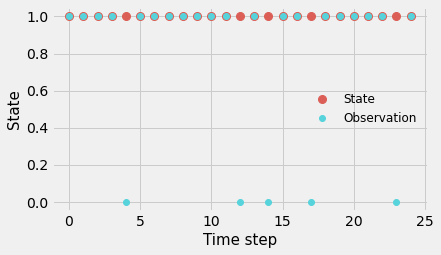

In [28]:
# We can plot the first 25 or so observations and states
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
Pal = sns.color_palette("hls", 2)

ax.plot(state[:25], 'o', color=Pal[0], markersize=8, label="State")
ax.plot(obs[:25], 'o', color=Pal[1], markersize=6, label="Observation")

ax.set_xlabel(r"Time step", fontsize=15)
ax.set_ylabel(r"State", fontsize=15)
ax.legend(fontsize=12, frameon=False)

In [29]:
# Now, we can look at calculating the Bayesian filter iteratively.
# We start by assuming a 50% probability of being in either state (although we
# could adjust this prior if we wanted)

# Note that this is BEFORE the first observation
bayes_est = np.array([0.5, 0.5])

# Now the update step is
bayes_est = hmm.A @ bayes_est
        
# And then the prediction step
bayes_est =hmm.B[:, obs[0]] * bayes_est
bayes_est = bayes_est / np.sum(bayes_est)

# Now this is the probability distribution AFTER the first observation
bayes_est


array([0.3, 0.7])

In [30]:
# Now we can track this over the entrore sequence of oservations to track the estimted probability over time
bayes_tracker = []
p1_tracker = []
bayes_est = np.array([0.5, 0.5])

for o in obs:
    bayes_est = hmm.A @ bayes_est
    bayes_est = hmm.B[:, o] * bayes_est
    bayes_est = bayes_est / np.sum(bayes_est)
    bayes_tracker.append(bayes_est)
    p1_tracker.append(bayes_est[1])


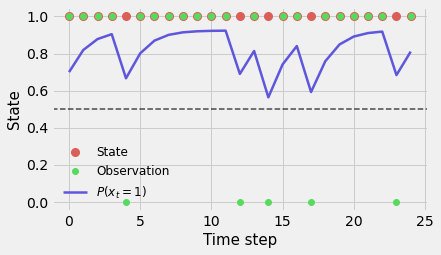

In [31]:
# And then we can plot the seqence of states and observations, along with the
# probability that the system is in state 1

fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
Pal = sns.color_palette("hls", 3)

ax.plot(state[:25], 'o', color=Pal[0], markersize=8, label="State")
ax.plot(obs[:25], 'o', color=Pal[1], markersize=6, label="Observation")
ax.plot(p1_tracker[:25], linewidth=2.5, color=Pal[2], label=r"$P(x_t = 1)$")

ax.axhline(0.5, linestyle='--', color='k', linewidth=1.5, alpha=0.7)

ax.set_xlabel(r"Time step", fontsize=15)
ax.set_ylabel(r"State", fontsize=15)
ax.legend(fontsize=12, frameon=False)

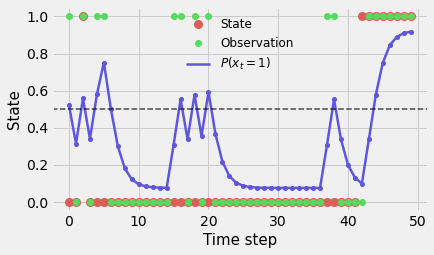

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
Pal = sns.color_palette("hls", 3)

ax.plot(state[-50:], 'o', color=Pal[0], markersize=8, label="State")
ax.plot(obs[-50:], 'o', color=Pal[1], markersize=6, label="Observation")
ax.plot(p1_tracker[-50:], linewidth=2.5, color=Pal[2], label=r"$P(x_t = 1)$")
ax.plot(p1_tracker[-50:], 'o', markersize=4, color=Pal[2])

ax.axhline(0.5, linestyle='--', color='k', linewidth=1.5, alpha=0.7)

ax.set_xlabel(r"Time step", fontsize=15)
ax.set_ylabel(r"State", fontsize=15)
ax.legend(fontsize=12, frameon=False)

In [35]:
# So, it looks to be working. 

### The backward algorithm

Now, before ending this notebook, we can introduce a related, but distinct algorithm known as *the backward algorithm*. Intuitively, the backward algorithm is the reverse-time version of the bayesian filtlering equations (or, in this context, by its more intuitive name, the forward algorithm). While it may seem that the backward algorithm has little to no practical use (as it requires the exclusive use of future information), it plays an important role in the process of *Bayesian smoothing*, which will be discussed in the next notebook.

Mathematically, we are attempting to estimate the quantity 

$$ P(x_k | y_{[k, T]}) $$

That is, the probability that the system is *currently* in state $x$ at time $t$, given knowledge of all *future* observations (until the end of the trajectory, after $T$ steps).

Mathematically, the process of solving this algorithm is identical to the Bayesian filter, we just need to flip the direction of time in the previous implementation.


In [37]:
# Specifically, we can calculate the backward-algorithm probabilities as


backward_tracker = []
p1_tracker_backward = []
backward_est = np.array([0.5, 0.5])

for o in np.flip(obs):
    backward_est = hmm.A @ backward_est
    backward_est = hmm.B[:, o] * backward_est
    backward_est = backward_est / np.sum(backward_est)
    backward_tracker.append(backward_est)
    p1_tracker_backward.append(backward_est[1])

backward_tracker = np.flip(backward_tracker)
p1_tracker_backward = np.flip(p1_tracker_backward)

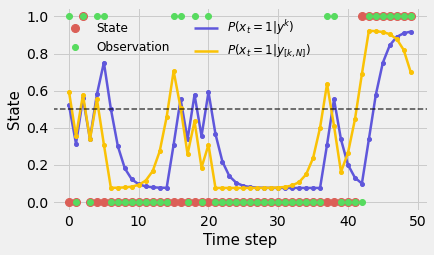

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))
Pal = sns.color_palette("hls", 3)

ax.plot(state[-50:], 'o', color=Pal[0], markersize=8, label="State")
ax.plot(obs[-50:], 'o', color=Pal[1], markersize=6, label="Observation")

ax.plot(p1_tracker[-50:], linewidth=2.5, color=Pal[2], label=r"$P(x_t = 1| y^k)$")
ax.plot(p1_tracker[-50:], 'o', markersize=4, color=Pal[2])

ax.plot(p1_tracker_backward[-50:], linewidth=2.5, color=sns.xkcd_rgb["goldenrod"], label=r"$P(x_t = 1| y_{[k, N]})$")
ax.plot(p1_tracker_backward[-50:], 'o', markersize=4, color=sns.xkcd_rgb["goldenrod"])


ax.axhline(0.5, linestyle='--', color='k', linewidth=1.5, alpha=0.7)

ax.set_xlabel(r"Time step", fontsize=15)
ax.set_ylabel(r"State", fontsize=15)
ax.legend(fontsize=12, frameon=False, ncol=2)

Here you can notice some significant differences between the forward and backward estimates. Namely, that the backward estiamte, when viewed in the forward direction of time, reacts to observations before they occur. In contrast the stadard forward algorithm cannot (by causality) achieve the same end, it can only change in reaction to observations

It may seem then, that the backward algorithm could contain useful information for diagnostic purposes after the fact, but, as one mught guess, a better choice for that type of analysis wouldbe the conditional probability of the hidden state at time $t$ conditioned on *all* of the information contained in the trajectory:

$$ P(x_k | y^T) $$

This is, in fact, exactly the quantity that so-called Bayesian smoothing os solving for, and the topic of discussion in the subsequent notebook